# Modeling

In [53]:
import requests
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [54]:
reddit = pd.read_csv('../datasets/reddit_final.csv')
reddit = reddit.drop(columns=['Unnamed: 0']) 

In [55]:
reddit.head(3)

,subreddit,selftext,gilded,title,subreddit_name_prefixed,hide_score,upvote_ratio,total_awards_received,is_reddit_media_domain,score,author_premium,edited,author_flair_richtext,is_self,author_flair_type,domain,allow_live_comments,archived,no_follow,is_crosspostable,over_18,awarders,can_gild,locked,treatment_tags,is_robot_indexable,num_comments,send_replies,author_patreon_flair,subreddit_subscribers,created_utc,num_crossposts,retrieved_utc,updated_utc,author_cakeday,subreddit_id_t5_2r0cn,removed_by_automod_filtered,removed_by_deleted,removed_by_reddit,removed_by_nan,thumbnail_nsfw,thumbnail_self,gildings_{},title_word_count,selftext_word_count,subreddit_id_t5_2txi0n,subreddit_id_t5_37roo,subreddit_id_t5_5iegdf,subreddit_id_t5_62obsy,subreddit_id_t5_6anqhn,subreddit_id_t5_6r00uj,subreddit_type_restricted,subreddit_type_user,thumbnail_other,gildings_'gid_2': 0,gildings_'gid_3': 0},gildings_{'gid_1': 0,gildings_{'gid_1': 1},gildings_{'gid_1': 4}
0,1,['none'],0,"['Im', 'f', 'love', 'fiancés', 'm', 'best', 'f...",1.0,1.0,1.0,0,1,1,1.0,1,1,1,1,1,1.0,1,1,1,1,1,1,0,1,1,1,1,1,8871630,1682548523,0,1682548537,1682548538,0,1.0,0.0,0,0.0,0,0,1,1,10,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,['none'],0,"['relationship', 'run', 'course']",1.0,1.0,1.0,0,1,1,1.0,1,1,1,1,1,1.0,1,1,1,1,1,1,0,1,1,1,1,1,8871630,1682548522,0,1682548537,1682548538,0,1.0,0.0,0,0.0,0,0,1,1,6,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,"['TLDR', 'mother', 'want', 'go', 'contact', 'a...",0,"['mom', 'f', 'want', 'm', 'cut', 'contact', 'a...",1.0,1.0,1.0,0,1,1,1.0,1,1,1,1,1,1.0,1,1,0,1,1,1,1,1,0,1,1,1,8871627,1682548515,0,1682548528,1682548529,0,1.0,0.0,0,0.0,1,0,1,1,15,700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
reddit.shape

(5998, 59)

## Train-Test-Split

In [57]:
X = reddit['title']
y = reddit['subreddit']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## Vectorizing  

tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Baseline 

In [59]:
baseline_accuracy = reddit['subreddit'].value_counts(normalize=True).max()
baseline_accuracy

0.5001667222407469

y_train.subreddit.value_counts(normalize=True)

The baseline model predicts AITA because it has more posts, and is accurate around 50.01% of the time 

## Logistic Regression with Titles 

#### Pipeline

In [60]:
# Define pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression(random_state=42))
])

In [61]:
pipeline.fit(X_train, y_train);

In [62]:
cross_val_score(pipeline, X_train, y_train, cv=3).mean()

0.9504523639334218

The cross validation score is high (0.95), meaning it should do well on new data. The model so far is able to predict the subreddit of 95% of the posts.

In [63]:
print(f'Train: {pipeline.score(X_train, y_train)}')
print(f'Test: {pipeline.score(X_test, y_test)}')

Train: 0.9735588375416865
Test: 0.9555555555555556


The model has a high accuracy score on both the training set (97.4%) and the test set (95.6%), which shows that the model is performing well on both datasets and is not overfitting much on the training data.

#### Hyperparameters 

##### Set hyperparameters 
param_grid = {
    'tfidf__max_df': [0.25, 0.5, 0.75],
    'tfidf__min_df': [1, 2, 5, 10, 20],
    'tfidf__max_features': [100, 200, 500, 1000, 1500, 2000],
    'lr__C': [0.1, 1, 10, 11, 12, 15, 20, 30],
    'lr__penalty': ['l2'], #tried l1 and got a warning, l2 was listed as best 
    'lr__solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'lr__max_iter': [100, 250, 500, 750, 1000]
}

##### Perform grid search
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

##### Print best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

##### Print training and testing accuracy with best hyperparameters
print(f"Train accuracy: {grid_search.best_score_}")
print(f"Test accuracy: {grid_search.score(X_test, y_test)}")

I made the first hyperparameter a markdown cell because it gave a lot of convergence warnings 

First hyperparameters:

Best hyperparameters: {'lr__C': 10, 'lr__max_iter': 100, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs', 'tfidf__max_df': 0.5, 'tfidf__max_features': 2000, 'tfidf__min_df': 1}
Train accuracy: 0.9702246502603901
Test accuracy: 0.9711111111111111

In [64]:
# Set hyperparameters 
param_grid2 = {
    'tfidf__max_df': [0.4, 0.5, 0.55],
    'tfidf__min_df': [1],
    'tfidf__max_features': [2000, 2500, 2900, 3000],
    'lr__C': [10],
    'lr__penalty': ['l2'], #tried l1 and got a warning, l2 was listed as best 
    'lr__solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'lr__max_iter': [100, 250, 500]
}

# Perform grid search
grid_search2 = GridSearchCV(pipeline, param_grid=param_grid2, cv=3, n_jobs=-1)
grid_search2.fit(X_train, y_train)

# Print best hyperparameters
print(f"Best hyperparameters: {grid_search2.best_params_}")

# Print training and testing accuracy with best hyperparameters
print(f"Train accuracy: {grid_search2.best_score_}")
print(f"Test accuracy: {grid_search2.score(X_test, y_test)}")

Best hyperparameters: {'lr__C': 10, 'lr__max_iter': 100, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs', 'tfidf__max_df': 0.5, 'tfidf__max_features': 2900, 'tfidf__min_df': 1}
Train accuracy: 0.9721302631131081
Test accuracy: 0.9744444444444444


In [65]:
# Set hyperparameters 
param_grid3 = {
    'tfidf__max_df': [0.49, 0.5, 0.51],
    'tfidf__min_df': [1],
    'tfidf__max_features': [2900, 2950, 2975, 2990],
    'lr__C': [10],
    'lr__penalty': ['l2'], #tried l1 and got a warning, l2 was listed as best 
    'lr__solver': ['lbfgs'],
    'lr__max_iter': [100, 101, 110]
}

# Perform grid search
grid_search3 = GridSearchCV(pipeline, param_grid=param_grid3, cv=3, n_jobs=-1)
grid_search3.fit(X_train, y_train)

# Print best hyperparameters
print(f"Best hyperparameters: {grid_search3.best_params_}")

# Print training and testing accuracy with best hyperparameters
print(f"Train accuracy: {grid_search3.best_score_}")
print(f"Test accuracy: {grid_search3.score(X_test, y_test)}")

Best hyperparameters: {'lr__C': 10, 'lr__max_iter': 100, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs', 'tfidf__max_df': 0.49, 'tfidf__max_features': 2900, 'tfidf__min_df': 1}
Train accuracy: 0.9721302631131081
Test accuracy: 0.9744444444444444


In [66]:
# Set hyperparameters 
param_grid4 = {
    'tfidf__max_df': [0.49, 0.48, 0.47, 0.46],
    'tfidf__min_df': [1],
    'tfidf__max_features': [2900, 2850, 2875, 2825],
    'lr__C': [10],
    'lr__penalty': ['l2'], #tried l1 and got a warning, l2 was listed as best 
    'lr__solver': ['lbfgs'],
    'lr__max_iter': [100]
}

# Perform grid search
grid_search4 = GridSearchCV(pipeline, param_grid=param_grid4, cv=3, n_jobs=-1)
grid_search4.fit(X_train, y_train)

# Print best hyperparameters
print(f"Best hyperparameters: {grid_search4.best_params_}")

# Print training and testing accuracy with best hyperparameters
print(f"Train accuracy: {grid_search4.best_score_}")
print(f"Test accuracy: {grid_search4.score(X_test, y_test)}")

Best hyperparameters: {'lr__C': 10, 'lr__max_iter': 100, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs', 'tfidf__max_df': 0.49, 'tfidf__max_features': 2900, 'tfidf__min_df': 1}
Train accuracy: 0.9721302631131081
Test accuracy: 0.9744444444444444


#### Best hyperparameters:

In [67]:
# Best
# Set hyperparameters 
best_param_grid = {
    'tfidf__max_df': [0.49],
    'tfidf__min_df': [1],
    'tfidf__max_features': [2900],
    'lr__C': [10],
    'lr__penalty': ['l2'], 
    'lr__solver': ['lbfgs'],
    'lr__max_iter': [100]
}

# Perform grid search
best_grid_search = GridSearchCV(pipeline, param_grid=best_param_grid, cv=3, n_jobs=-1)
best_grid_search.fit(X_train, y_train)

# Print best hyperparameters
print(f"Best hyperparameters: {best_grid_search.best_params_}")

# Print training and testing accuracy with best hyperparameters
print(f"Train accuracy: {best_grid_search.best_score_}")
print(f"Test accuracy: {best_grid_search.score(X_test, y_test)}")

Best hyperparameters: {'lr__C': 10, 'lr__max_iter': 100, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs', 'tfidf__max_df': 0.49, 'tfidf__max_features': 2900, 'tfidf__min_df': 1}
Train accuracy: 0.9721302631131081
Test accuracy: 0.9744444444444444


In [68]:
preds = best_grid_search.predict(X_test)

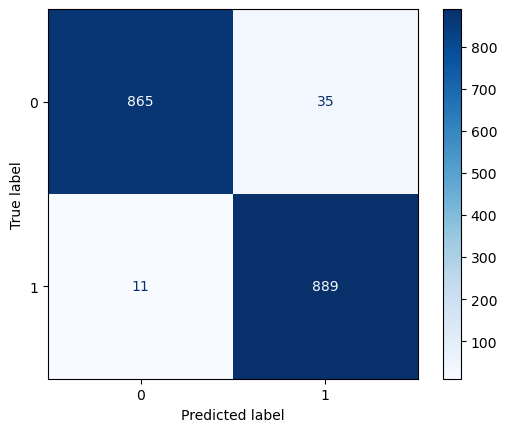

In [69]:
ConfusionMatrixDisplay.from_estimator(best_grid_search, X_test, y_test, cmap='Blues');

#### Confusion Matrix:

##### Predicted AITA when actually Relationship Advice: 11
##### Predicted AITA True: 865
##### Predicted Relationship Advice when actually AITA: 35 
##### Predicted Relationship Advice True: 889

In [70]:
f1_score(y_test, preds)

0.9747807017543859

Based on the train and test accuracies and the f1-score all being ~ 97%, they show the model performs well in predicting the correct subreddit based on the titles in the training data as well as new, unseen data. The amount of false predictions are very low. It performs much better than the baseline of 50%.

## Decision Tree with Titles 

#### Pipline 

In [71]:
pipeline_tree = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('dt', DecisionTreeClassifier(random_state=42))
])

In [72]:
pipeline_tree.fit(X_train, y_train);

In [73]:
cross_val_score(pipeline_tree, X_train, y_train, cv=3).mean()

0.9621248170461895

The cross validation score is higher than the logistic regression model (0.95), with a cross-val score of 0.96. The model so far is able to predict the subreddit of 96% of the posts.

In [74]:
print(f'Train: {pipeline_tree.score(X_train, y_train)}')
print(f'Test: {pipeline_tree.score(X_test, y_test)}')

Train: 0.9969032872796569
Test: 0.9788888888888889


The model has a high accuracy score on both the training set (99.6%) and the test set (97.8%), which shows that the model is performing well on both datasets, but seems to be overfitting a little on the training data.

#### Hyperparameters 

##### Set hyperparameters
param_grid_tree = {
    'tfidf__max_df': [0.49],
    'tfidf__min_df': [1],
    'tfidf__max_features': [2900],
    'dt__max_depth': [5, 10, 15, 20, 25],
    'dt__min_samples_split': [2, 5, 10, 20, 30],
    'dt__min_samples_leaf': [1, 2, 5, 10, 20],
    'dt__max_leaf_nodes': [10, 50, 100]
}

##### Perform grid search
grid_search_tree = GridSearchCV(pipeline_tree, param_grid=param_grid_tree, cv=3, n_jobs=-1)
grid_search_tree.fit(X_train, y_train)

##### Print best hyperparameters
print(f"Best hyperparameters: {grid_search_tree.best_params_}")

##### Print training and testing accuracy with best hyperparameters
print(f"Train accuracy: {grid_search_tree.best_score_}")
print(f"Test accuracy: {grid_search_tree.score(X_test, y_test)}")

I set this as a markdown cell because it took a long time to run

Best hyperparameters: {'dt__max_depth': 25, 'dt__max_leaf_nodes': 50, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 2, 'tfidf__max_df': 0.49, 'tfidf__max_features': 2900, 'tfidf__min_df': 1}
Train accuracy: 0.9449734504237721
Test accuracy: 0.9444444444444444

In [75]:
# Set hyperparameters
param_grid_tree2 = {
    'tfidf__max_df': [0.49],
    'tfidf__min_df': [2],
    'tfidf__max_features': [2800, 2900, 3000],
    'dt__max_depth': [25, 26, 27, 30],
    'dt__min_samples_split': [2],
    'dt__min_samples_leaf': [2],
    'dt__max_leaf_nodes': [45, 50, 55]
}

# Perform grid search
grid_search_tree2 = GridSearchCV(pipeline_tree, param_grid=param_grid_tree2, cv=3, n_jobs=-1)
grid_search_tree2.fit(X_train, y_train)

# Print best hyperparameters
print(f"Best hyperparameters: {grid_search_tree2.best_params_}")

# Print training and testing accuracy with best hyperparameters
print(f"Train accuracy: {grid_search_tree2.best_score_}")
print(f"Test accuracy: {grid_search_tree2.score(X_test, y_test)}")

Best hyperparameters: {'dt__max_depth': 30, 'dt__max_leaf_nodes': 45, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 2, 'tfidf__max_df': 0.49, 'tfidf__max_features': 2800, 'tfidf__min_df': 2}
Train accuracy: 0.9456892678443786
Test accuracy: 0.9422222222222222


In [76]:
# Set hyperparameters
param_grid_tree3 = {
    'tfidf__max_df': [0.49],
    'tfidf__min_df': [2],
    'tfidf__max_features': [2000, 2500, 2800],
    'dt__max_depth': [30, 40, 50],
    'dt__min_samples_split': [2],
    'dt__min_samples_leaf': [2],
    'dt__max_leaf_nodes': [30, 40, 45]
}

# Perform grid search
grid_search_tree3 = GridSearchCV(pipeline_tree, param_grid=param_grid_tree3, cv=3, n_jobs=-1)
grid_search_tree3.fit(X_train, y_train)

# Print best hyperparameters
print(f"Best hyperparameters: {grid_search_tree3.best_params_}")

# Print training and testing accuracy with best hyperparameters
print(f"Train accuracy: {grid_search_tree3.best_score_}")
print(f"Test accuracy: {grid_search_tree3.score(X_test, y_test)}")

Best hyperparameters: {'dt__max_depth': 50, 'dt__max_leaf_nodes': 45, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 2, 'tfidf__max_df': 0.49, 'tfidf__max_features': 2000, 'tfidf__min_df': 2}
Train accuracy: 0.948785527077164
Test accuracy: 0.9461111111111111


In [77]:
# Set hyperparameters
param_grid_tree4 = {
    'tfidf__max_df': [0.49],
    'tfidf__min_df': [2],
    'tfidf__max_features': [50, 100, 200, 1000, 2000],
    'dt__max_depth': [50, 100, 200, 1000],
    'dt__min_samples_split': [2],
    'dt__min_samples_leaf': [2],
    'dt__max_leaf_nodes': [44, 45, 46]
}

# Perform grid search
grid_search_tree4 = GridSearchCV(pipeline_tree, param_grid=param_grid_tree4, cv=3, n_jobs=-1)
grid_search_tree4.fit(X_train, y_train)

# Print best hyperparameters
print(f"Best hyperparameters: {grid_search_tree4.best_params_}")

# Print training and testing accuracy with best hyperparameters
print(f"Train accuracy: {grid_search_tree4.best_score_}")
print(f"Test accuracy: {grid_search_tree4.score(X_test, y_test)}")

Best hyperparameters: {'dt__max_depth': 50, 'dt__max_leaf_nodes': 45, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 2, 'tfidf__max_df': 0.49, 'tfidf__max_features': 2000, 'tfidf__min_df': 2}
Train accuracy: 0.948785527077164
Test accuracy: 0.9461111111111111


#### Best hyperparameters:

In [78]:
# Best
# Set hyperparameters
best_param_grid_tree = {
    'tfidf__max_df': [0.49],
    'tfidf__min_df': [2],
    'tfidf__max_features': [2000],
    'dt__max_depth': [50],
    'dt__min_samples_split': [2],
    'dt__min_samples_leaf': [2],
    'dt__max_leaf_nodes': [45]
}

# Perform grid search
best_grid_search_tree = GridSearchCV(pipeline_tree, param_grid=best_param_grid_tree, cv=3, n_jobs=-1)
best_grid_search_tree.fit(X_train, y_train)

# Print best hyperparameters
print(f"Best hyperparameters: {best_grid_search_tree.best_params_}")

# Print training and testing accuracy with best hyperparameters
print(f"Train accuracy: {best_grid_search_tree.best_score_}")
print(f"Test accuracy: {best_grid_search_tree.score(X_test, y_test)}")

Best hyperparameters: {'dt__max_depth': 50, 'dt__max_leaf_nodes': 45, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 2, 'tfidf__max_df': 0.49, 'tfidf__max_features': 2000, 'tfidf__min_df': 2}
Train accuracy: 0.948785527077164
Test accuracy: 0.9461111111111111


In [79]:
preds = best_grid_search_tree.predict(X_test)

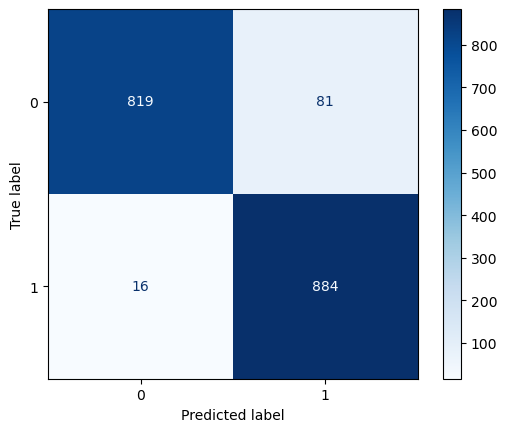

In [80]:
ConfusionMatrixDisplay.from_estimator(best_grid_search_tree, X_test, y_test, cmap='Blues');

#### Confusion Matrix:

##### Predicted AITA when actually Relationship Advice: 16
##### Predicted AITA True: 819
##### Predicted Relationship Advice when actually AITA: 81 
##### Predicted Relationship Advice True: 884  

In [81]:
f1_score(y_test, preds)

0.9479892761394102

Based on the train and test accuracies and the f1-score all being ~ 94%, they show the model performs well in predicting the correct subreddit based on the titles in the training data as well as new, unseen data. The amount of false predictions are relatively low. It performs much better than the baseline of 50%, but the logistic regression model performs better.